In [1]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd
from typing import List

from utils.plotters import plot_solution
from utils.data_loaders import read_solution
from utils.models import Customer, Route, RunningSheet
from utils.log import LoggerFactory

from aco.colony import Colony

logger_factory = LoggerFactory()

## [1] Load Data

In [2]:
SOLUTION = read_solution('data/raw/sintef_routes.txt')
locations = pd.read_csv('data/processed/c101.csv')
solution_locations = np.sum([len(route) for _, route in SOLUTION.items()])
print(f"Number of Locations in Customers[{len(locations)}], Solution[{solution_locations}]")
locations.head()

Number of Locations in Customers[101], Solution[100]


,CustomerNO,Lng,Lat,Demand,ReadyTime,Due,ServiceTime
0,1,40.0,50.0,0.0,0.0,1236.0,0.0
1,2,45.0,68.0,10.0,912.0,967.0,90.0
2,3,45.0,70.0,30.0,825.0,870.0,90.0
3,4,42.0,66.0,10.0,65.0,146.0,90.0
4,5,42.0,68.0,10.0,727.0,782.0,90.0


In [3]:
""" Descriptive Statistics of the Customers.
iloc[1:] is used to exclude the depot from the statistics.
"""
locations.iloc[1:].describe()

,CustomerNO,Lng,Lat,Demand,ReadyTime,Due,ServiceTime
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,51.500000,42.300000,48.590000,18.100000,426.800000,487.560000,90.0
std,29.011492,22.977591,21.367915,10.415121,282.203738,282.053198,0.0
min,2.000000,0.000000,5.000000,10.000000,10.000000,67.000000,90.0
25%,26.750000,25.000000,32.000000,10.000000,177.500000,237.750000,90.0
50%,51.500000,40.000000,47.500000,10.000000,417.500000,480.000000,90.0
75%,76.250000,58.500000,66.000000,20.000000,645.500000,710.000000,90.0
max,101.000000,95.000000,85.000000,50.000000,1054.000000,1127.000000,90.0


## [1.1] Optimal Solution

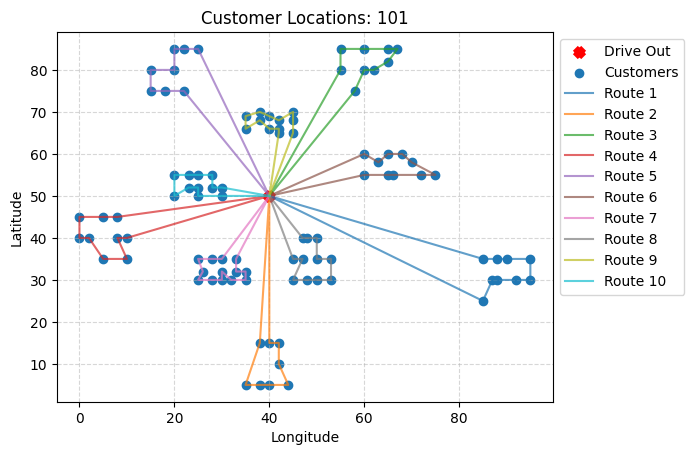

In [4]:
plot_solution(locations, SOLUTION)

## [2] Preprocessing

### [2.1] Remove origin
This dataset consists of 100 customers. But as you can see above, we currently have 101 rows. This is because the first index is the 'Driveout' location / 'Origin'. Thus, we need to remove this from the customers_data.

In [5]:
origin = locations.iloc[0]

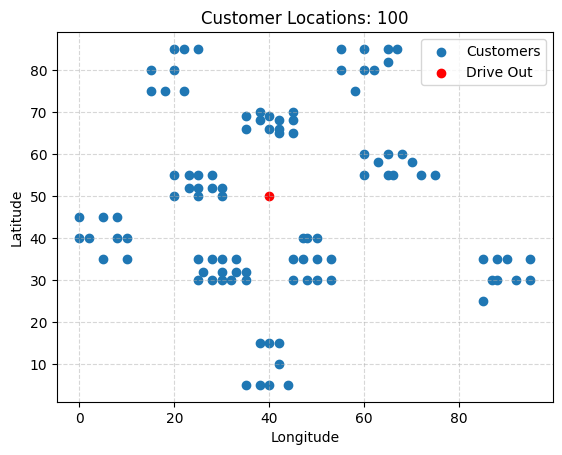

In [6]:
plt.title(f'Customer Locations: {len(locations) - 1}')
plt.scatter(locations.iloc[1:]['Lng'], locations.iloc[1:]['Lat'])
plt.scatter(origin['Lng'], origin['Lat'], color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(['Customers', 'Drive Out'])
plt.grid(linestyle='--', alpha=0.5)
plt.show()

## [3] Problem

**REFERENCES**

Mirjalili, Ali, *Youtube*, https://www.youtube.com/watch?v=783ZtAF4j5g
(Cannot use graphs, must use matrixes for the mathematical modelling)[11:30]

• Depot: The starting and ending point for all vehicles. 
• Customers: Each customer has a location, a demand for goods, a time window for 
receiving the delivery, and a service time. 
• Vehicles:  Each  vehicle  has  a  limited  capacity  and  must  return  to  the  depot  after 
completing its route. 

### [3.1] Constraints
1. Each customer is visited exactly once by one vehicle. 
2. Deliveries occur within the specified time windows. 
3. The total demand on any route does not exceed the vehicle's capacity.

## Constants [PARAMETERS]

In [7]:
""" HYPERPARAMETERS """
ALPHA = .5
BETA = .6
TAU = 1
EVAPORATION_RATE = .5

""" PARAMETERS """
N_VEHICLES = 10
N_ITERATIONS = 2
VEHICLE_CAPACITY = 200
MATRIX_SHAPE = (len(locations), len(locations), N_ITERATIONS + 1) # +1 for convenience in the training loop.

""" PARAMETER CHECKS """
assert N_VEHICLES * VEHICLE_CAPACITY >= len(locations) - 1, "Not enough capacity to serve all customers"
assert 0 <= EVAPORATION_RATE <= 1, "Evaporation rate must be between 0 and 1"
assert 0 <= ALPHA <= 1, "Alpha must be between 0 and 1"
assert 0 <= BETA <= 1, "Beta must be between 0 and 1"

assert MATRIX_SHAPE == (101, 101, N_ITERATIONS + 1), "Matrix shape must be (101, 101, 10)"

In [10]:
sheet = RunningSheet.from_pd(locations, logger_factory)
colony = Colony(sheet, logger_factory)
vehicles = colony.optimize(N_ITER=2, N_VEHICLES=10, CAPACITY=200, ALPHA=0.5, BETA=0.5, TAU=1.0, Q=0.5, P=0.5)

[RunningSheet(13)][2024-10-15 18:13:36][INFO] Creating RunningSheet object with [100] customers. 
[Colony(13)][2024-10-15 18:13:36][INFO] Creating colony object. 
[Colony(13)][2024-10-15 18:13:36][INFO] Optimizing the running sheet. 
[Colony(10)][2024-10-15 18:13:36][DEBUG] Initializing pheromones with shape (101, 101, 3). 
[Colony(10)][2024-10-15 18:13:36][DEBUG] Starting Iteration(1/2). 
[RunningSheet(10)][2024-10-15 18:13:36][DEBUG] Resetting all customers, depot is staying as completed. 
[RunningSheet(10)][2024-10-15 18:13:36][DEBUG] Completed customers: 0/100. 
[RunningSheet(10)][2024-10-15 18:13:36][DEBUG] Completed customers: 1/100. 
[Colony(10)][2024-10-15 18:13:36][DEBUG] Available customers: 99. 
[Colony(10)][2024-10-15 18:13:36][DEBUG] Calculating probability for 76.0 -> 1.0. shape((101, 101, 3)), dtype: float64. 
[Colony(10)][2024-10-15 18:13:36][DEBUG] Distance table shape: (101, 101), d=float64. 
[Colony(10)][2024-10-15 18:13:36][DEBUG] Calculating probability for 76.0 ->

In [ ]:
plt.title(f'Customer Locations: {len(locations) - 1}')
plt.scatter(locations.iloc[1:]['Lng'], locations.iloc[1:]['Lat'])
plt.scatter(origin['Lng'], origin['Lat'], color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

for vehicle in vehicles:
    lats = [sheet.depot.lat] + [b.to_customer.lat for b in vehicle.get_route()]
    lngs = [sheet.depot.lng] + [b.to_customer.lng for b in vehicle.get_route()]

    plt.plot(lngs, lats, color='black')

plt.plot(lngs, lats, color='black')

plt.legend(['Customers', 'Drive Out'])
plt.grid(linestyle='--', alpha=0.5)
plt.show()

## Variable Initializations

In [10]:
""" Initialize Pheromone Table
SHAPE: (i, j, t) -> (location i, location j, iteration t) -> (101 customer location x 101 customer location x 10 iterations).
All start at TAU.
"""
pheromone_table = np.full(MATRIX_SHAPE, dtype=np.float64, fill_value=TAU)

""" Initialize Distance Table
SHAPE: (i, j) -> (location i, location j) -> (101 customer location x 101 customer location).
DEPOT = (0, 0)
Location i = j is 0 because it is the same location.
Formula to calculate distance between two locations: sqrt((x1 - x2)^2 + (y1 - y2)^2). Distance between customer i and customer j.
"""
DISTANCE_TABLE = np.array([[(np.sqrt((customer['Lat'] - other['Lat'])**2 + (customer['Lng']- other['Lng'])**2)) for _, other in locations.iterrows()] for _, customer in locations.iterrows()])
assert DISTANCE_TABLE.shape == (101, 101), "Distance table shape must be (101, 101)"

### Ant move to node probability formula
**We should set allowed to only be the most near neighbours**

$$P_{ij}(t) =\frac{[\tau_{ij}(t)]^\alpha * [n_{ij}]^\beta}{\sum_{k \in allowed}[\tau_{ik}(t)]^\alpha * [n_{ik}]^\beta}$$

In [11]:
class Vehicle:
    def __init__(self, id: int, capacity: int, depot: Customer):
        self.id = id
        self.capacity = capacity
        self.depot = depot

        self.current_load = 0.0
        self.current_time = 0.0

        self.route: List[Route] = []
        self.current_customer = depot
        self.shift_end = depot.due_time

        self.is_retired = False
    
    def restart_route(self) -> None:
        self.current_customer = self.depot
        self.current_time = 0.0 # Start at 10:00
        self.current_load = 0.0
        self.is_retired = False
    
    def get_total_distance(self) -> float:
        return sum([route.distance() for route in self.route])
    
    def move_to_depot(self) -> Route:
        route = self.add_customer(self.depot)
        return route

    def find_next_customer(self, outstanding_customers: list[Customer], pheromone: NDArray[np.float64], distance: NDArray[np.float64], alpha: float, beta: float) -> Customer | None:
        allowed_customers = [customer for customer in outstanding_customers if self.can_accommodate(customer)]

        if len(allowed_customers) == 0:
            self.is_retired = True
            return None
        
        if len(allowed_customers) == 1:
            return allowed_customers[0]

        def calculate_probability_at_node(i: int, j: int, allowed: List[int], pheromone: np.ndarray, distance: np.ndarray, alpha: float, beta: float) -> float:
            objective = (distance[i, j] ** beta)
            nominator = (pheromone[i, j] ** alpha) * objective
            denominator = np.array([(pheromone[i, k] ** alpha) * (distance[i, k] ** beta) for k in allowed]).sum()
            return nominator / denominator

        allowed_indices = [customer.customer_no for customer in allowed_customers]
        probabilities = [calculate_probability_at_node(self.current_customer.customer_no, j, allowed_indices, pheromone, distance, alpha, beta) for j in allowed_indices]

        cumulative_sum = np.cumsum(probabilities)
        random_number = np.random.rand()

        node = - 1
        for index, cumulative_prob in enumerate(cumulative_sum):
            if random_number <= cumulative_prob:
                node = index
        
        assert node != -1, "No node was selected."

        return allowed_customers[node]
        
    def is_at_depot(self) -> bool:
        return self.current_customer == self.depot

    def add_customer(self, customer: Customer) -> Route:
        # Ensure the vehicle can do the customer
        route = Route(self.current_customer, customer) # Will be used to do much more cool thing!
        print(customer)

        self.route.append(route)
        self.current_customer = customer

        self.current_load += customer.demand

        # Does not account for waiting time (such as driving distance to the customer)
        print(f"Vehicle {self.id} is at customer {customer.customer_no}. Load: {self.current_load}, Distance: {self.get_total_distance()}, Time: {self.current_time}")
        self.current_time += customer.service_time
        print(f"Vehicle {self.id} is done with customer {customer.customer_no}, service-time{customer.service_time}. Time: {self.current_time}")
        return route
    
    def can_accommodate(self, customer: Customer) -> bool:
        if not self.is_within_time_window(customer):
            print(f"Cannot do customer {customer.customer_no} because it is outside the time window.")
            return False

        # Calculate the total load if the customer is added
        total_load = self.current_load + customer.demand
        
        # Check if the total load exceeds the vehicle's load limit
        if total_load <= self.capacity:
            return True
        else:
            print(f"Cannot accommodate customer {customer.customer_no} due to load limit.")
            return False
    
    def is_within_time_window(self, customer: Customer) -> bool:
        is_customer_ready = self.current_time >= customer.ready_time
        print(f"Customer {customer.customer_no} is ready[{customer.ready_time}]: {is_customer_ready}. Current time: {self.current_time}")

        is_within_customer_due = self.current_time <= customer.due_time
        print(f"Customer {customer.customer_no} is within due time[{customer.due_time}]: {is_within_customer_due}, Current time: {self.current_time}")

        is_within_depot_due = (self.current_time + customer.service_time) <= self.depot.due_time
        print(f"Customer {customer.customer_no} is within depot due time[{self.depot.due_time}]: {is_within_depot_due}, Current time: {self.current_time}")

        return is_customer_ready and is_within_customer_due and is_within_depot_due
    
    def __len__(self) -> int:
        """ Gets the number of customers in the route.

        Returns:
            int: Number of customers in the route. 
        """
        return len(self.route)

In [ ]:
customers = RunningSheet.from_pd(locations, logger_factory)
distance_table = customers.get_distance_table()

vehicles = [Vehicle(id + 1, VEHICLE_CAPACITY, customers.depot) for id in range(N_VEHICLES)]

assert all(vehicle.is_at_depot() for vehicle in vehicles), "All vehicles are not starting at the depot.[Constraint Violation]"
assert all(vehicle.current_load == 0 for vehicle in vehicles), "All vehicles do not have a load of 0."
assert not customers.all_completed(), "All customers are already completed."

In [ ]:
Q = 1
# Assuming vehicles is a list of Vehicle objects and customer_pool is a list of Customer objects
for t in range(N_ITERATIONS):
    """ Prepare the pheromone table for next iteration.
    This means that we evaporate the peromones for the next iteration, even iteration + 1, because of convenience.
    FORMULA: t_{i,j} <- (1 - EVAPORATION_RATE) * t_{i,j}
    """
    pheromone_table[:, :, t + 1] = (1 - EVAPORATION_RATE) * pheromone_table[:, :, t] # Evaporate Pheromones

    customers.reset()

    for vehicle in vehicles:
        vehicle.restart_route()
        while True:
            next_customer = vehicle.find_next_customer(customers.get_remaining_customers(), pheromone_table[:, :, t], distance_table, ALPHA, BETA)
            if next_customer is None:
                break
            
            try:
                print(f"Vehicle {vehicle.id} is moving to customer {next_customer.customer_no}.")
                route = vehicle.add_customer(next_customer)
                """ Do not know if we should complete customer or not, before after all vehicles has done their turn."""
                next_customer.complete()

                """ Update Pheromones on the route (trail) i, j.
                Formula: sum_k(Q / L_k) where L_k is the total distance of the route. 0 if no route.
                FORMULA: t_{i,j} <- t_{i,j} + (Q * (1 / L_k))
                k is for all vehicles. But since we are doing it for each vehicle, we can just add Q / L_k.
                """
                delta_t_ij = 1 / route.distance()
                pheromone_table[route.from_customer.customer_no, route.to_customer.customer_no, t + 1] += (Q / delta_t_ij)# t + 1 for convenience.
            except AssertionError as e:
                print(f"Error: {e}")
                break  # Stop if an error occurs

        route = vehicle.move_to_depot() # Add the depot to the end of the route
        if route.distance() != 0.0:
            delta_t_ij = 1 / route.distance()
            pheromone_table[route.from_customer.customer_no, route.to_customer.customer_no, t + 1] += (Q / delta_t_ij) # t + 1 for convenience.

In [ ]:
for vehicle in vehicles:
    print(f"Vehicle {vehicle.id} - Load: {vehicle.current_load}, Distance: {vehicle.get_total_distance()}, Route: {vehicle.route}")

print(f"Customers: {customers.all_completed()}")

In [ ]:
print(SOLUTION)

In [ ]:
plt.title(f'Customer Locations: {len(locations) - 1}')
plt.scatter(locations.iloc[1:]['Lng'], locations.iloc[1:]['Lat'])
plt.scatter(origin['Lng'], origin['Lat'], color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(linestyle='--', alpha=0.5)

for vehicle in vehicles:
    route = vehicle.route
    lats = [customer.lat for customer in route]
    lngs = [customer.lng for customer in route]
    plt.plot(lngs, lats, label=f'Vehicle {vehicle.id}')

plt.legend(['Customers', 'Drive Out', 'Route 1', 'Route 2', 'Route 3', 'Route 4', 'Route 5', 'Route 6', 'Route 7', 'Route 8', 'Route 9', 'Route 10'])
plt.show()